# Parameterization Experiments

In this notebook, we'll illustrate the process of learning a *parameterized* form for $\Omega$ from data with true labels. 

In [1]:
using StatsBase
using Combinatorics
using Plots
using Optim

include("jl/omega.jl")
include("jl/HSBM.jl")
include("jl/read_data.jl")
include("jl/inference.jl")
include("jl/objectives.jl");

# Second Attempt

In [42]:
function plotα(dataset, kmax_)
    H, Z = read_hypergraph_data(dataset,kmax_)
    
    if haskey(H.E, 1) delete!(H.E, 1) end
    v = sort(collect(keys(H.E)))
    
    kmax = maximum(v)
    
    K_map = Dict(v[i] => i for i in 1:length(v))
    
    lk = length(K_map)
    α0 = vcat(1 .+ rand(kmax),  0.25.+0.5*rand(kmax))
    
    n = 1*length(H.D)
    
    function ω(p, α, K_map)
        k_ = sum(p)
        if haskey(K_map, k_) 
            k = K_map[k_]
            return (p[1] / k)^α[k]  / n^(α[lk+k]*k)
        else
            return 1
        end
    end
    
    Ω = buildΩ((p, α) -> ω(p,α,K_map), α0, kmax);
    
    ℓ = maximum(k for k in keys(H.E)) # size of largest hyperedge

    C       = evalCuts(Z,H)
    V, μ, S = evalSums(Z,H,ℓ,true);

    
    α = α0
    res = 0
    
    function objective(a, ix)
        alph = copy(α)
        alph[ix] = a[1]
        obj = 0.0
        for p in keys(S)
            Op = Ω(p; α=alph, mode="partition")
            obj -= S[p]*Op
            if p in keys(C)
                obj += C[p]*log(Op)
            end
        end
        return -obj # for minimization
    end
    
    for i = 1:20
        for h in 1:lk
            res = optimize(a -> objective(a, h+lk), 0.0, 3.0)
            α[h+lk] = Optim.minimizer(res)[1]
            
            res = optimize(a -> objective(a, h), 0.0, 100.0)
            α[h] = Optim.minimizer(res)[1]
        end

#         println(α)
    end
    
    println(round(convert(Float64, Optim.minimum(res)[1]), digits = 3))
    
    p1 = plot(v, α[1:lk], seriestype = :scatter, label="", title = dataset)
    ylabel!("α")
    p2 = plot(v, α[(lk+1):(2*lk)], seriestype = :scatter, label="", color = "orange")
    ylabel!("β")
    ylims!((0,4))
    
    l = @layout [a ; b]
    
    return plot(p1, p2, layout = l)
    
end
        
    
    


plotα (generic function with 1 method)

In [43]:
# note: this computation slows down significantly for large kmax

kmax = 15

p1 = plotα("TrivagoClickout",        kmax)
p2 = plotα("walmart-trips",          kmax)
p3 = plotα("congress-bills",         kmax);
p4 = plotα("contact-primary-school", kmax);

7.2853098433698e10
4.088249093e6
5.120055883e6
200387.794


# Conjecture

The other three plots are all behaving badly because they don't have edges of size 1, and in some cases size 2. In general, it looks like the implemented function will not perform well when we are missing edges of a given size, which makes sense. 

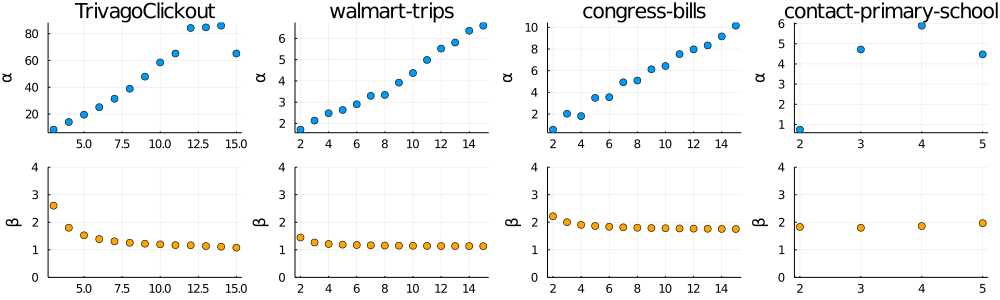

In [45]:
l = @layout [a b c d]
plot(p1, p2, p3, p4, layout = l, size = (1000, 300))